>    # Logistic Regression on Amazon Fine Foods Reviews

The objective of this assignment is to understand the working of Logistic Regression on Amazon Fine Foods Review Dataset.
The main steps to be followed in this assignment are as follows - 
1. Apply Logistic regression on all the four vectorizers.
2. Performing perturbation test:
a. Get the weights W after fit your model with the data X
b. Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)
c. we fit the model again on data X' and get the weights W'
d. find the % change between W and W' 
e. print the features whose % change is more than a threshold x. Optimum threshold to be identified using Elbow Method

4. Choose different metric other than accuracy for choosing the best hyperparameter,
which is apt for imbalanced datasets and accuracy sometimes gives us false conclusions
about the model performance sometimes.
5. Do hyperparameter tuning or some feature engineering and make your model better by
reducing the false positives.
6. Get important features for both positive and negative classes separately.
7. Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is
recommended.

**Kaggle Dataset Location** - https://www.kaggle.com/snap/amazon-fine-food-reviews/data



## Preparing the Data 

In [1]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from scipy.sparse import find

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


###  Importing Dataset from database.sqlite and ignoring reviews with Score  = 3 as they represent a neutral view**

In [2]:
# creating sql connection string
con = sqlite3.connect('AmazonReviews.sqlite')

In [3]:
#Positive Review - Rating above 3
#Negative Review - Rating below 3
#Ignoring Reviews with 3 Rating

filtered_data = pd.read_sql_query('SELECT * from Reviews WHERE Score != 3',con)

In [4]:
# mapping ratings above 3 as Positive and below 3 as Negative

actual_scores = filtered_data['Score']
positiveNegative = actual_scores.map(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data['Score'] = positiveNegative

In [5]:
filtered_data.head(5)

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  Positive  1303862400   
1                     0                       0  Negative  1346976000   
2                     1                       1  Positive  1219017600   
3                     3                       3  Negative  1307923200   
4                     0                       0  Positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

### Data Preprocessing

In [6]:
final = filtered_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [7]:
print('Rows dropped : ',filtered_data.size - final.size)
print('Percentage Data remaining after dropping duplicates :',(((final.size * 1.0)/(filtered_data.size * 1.0) * 100.0)))

Rows dropped :  1616410
Percentage Data remaining after dropping duplicates : 69.25890143662969


In [8]:
# Dropping rows where HelpfulnessNumerator < HelpfulnessDenominator
final = final[final.HelpfulnessDenominator >= final.HelpfulnessNumerator]

In [9]:
print('Number of Rows remaining in the Dataset: ',final.size)

Number of Rows remaining in the Dataset:  3641710


In [10]:
# Checking the number of positive and negative reviews
final['Score'].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [11]:
# Data Sampling
final = final.iloc[:200000,:]

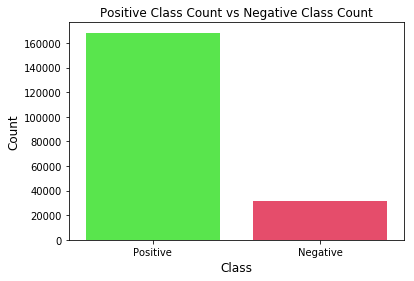

Positive    168330
Negative     31670
Name: Score, dtype: int64


In [12]:
# Checking the number of positive and negative reviews

Class_Count  = final['Score'].value_counts()

plt.figure()
flatui = ["#15ff00", "#ff0033"]
sns.set_palette(flatui)
sns.barplot(Class_Count.index, Class_Count.values, alpha=0.8 )
plt.title('Positive Class Count vs Negative Class Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()

print(final['Score'].value_counts())

### Time Based Splitting

In [13]:
# Sorting values according to Time for Time Based Slicing
final = final.sort_values('Time',kind = 'quicksort')

### Cleaning Data - Stop Words Removal,Stemming,Removing HTML tags and Special Characters

In [14]:
# Function to Remove HTML Tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,"",sentence)
    return cleantext

In [15]:
# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [16]:
# Initialize Stop words and PorterStemmer and Lemmetizer
stop = set(stopwords.words('english'))
sno = SnowballStemmer('english')


#print(stop)
#print('*' * 100)
#print(sno.stem('tasty'))

In [17]:

# Cleaning HTML and non-Alphanumeric characters from the review text
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 200000/200000 [03:46<00:00, 881.78it/s] 


In [18]:
final['CleanedText']=final_string
final.head(5)

Id   ProductId          UserId         ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040   AJ46FKXOVC7NR  Nicholas A Mesiano   
212472  230285  B00004RYGX  A344SMIA5JECGM     Vincent P. Ross   
212533  230348  B00004RYGX  A1048CYU0OV4O8        Judy L. Eans   
212458  230269  B00004RYGX   A1B2IZU1JLZA6                 Wes   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
138706                     0                       0  Positive  939340800   
138683                     2                       2  Positive  940809600   
212472                     1                       2  Positive  944438400   
212533                     2                       2  Positive  947376000   
212458                    19                      23  Negative  948240000   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
212472                            A modern day fairy tale   
212533                                              GREAT   
212458    WARNING: CLAMSHELL EDITION IS EDITED TV VERSION   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   
212472  A twist of rumplestiskin captured on film, sta...   
212533  THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...   
212458  I, myself always enjoyed this movie, it's very...   

                                              CleanedText  
138706  b'witti littl book make son laugh loud recit c...  
138683  b'rememb see show air televis year ago child s...  
212472  b'twist rumplestiskin captur film star michael...  
212533  b'one movi movi collect fill comedi action wha...  
212458  b'alway enjoy movi funni entertain didnt hesit...

### Logistic Regression using GridSearchCV and RandomSearchCV for optimum hyper-parameter selection



In [19]:
#Dictionary for storing Metrics
Final_Metrics =pd.DataFrame(columns=['Algorithm','Vectorization','HyperParameter','Training Accuracy Score','Testing Accuracy Score','F1 Score',
                            'Precision Score',
                            'Recall Score'])
Final_List = []

In [20]:
# Logistic Regression Function
def runLogisticRegression(X_Train,X_Test,Y_Train,Y_Test,algoName):
    penalty = ['l1','l2']
    searchTypes = ['GridSearch','RandomSearch']
    gridSearch_Parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    randomSearch_Parameters = {'C':uniform()}
    
    for search in searchTypes:
        if search == 'GridSearch':
            for item in penalty:
                print('Logistic Regression using GridSearchCV on' , algoName,' with Regularizer = ',item)
                logistic = LogisticRegression(penalty=item,class_weight= 'balanced')
                gridsearchModel = GridSearchCV(logistic,gridSearch_Parameters,cv= 10,scoring= 'f1_weighted',n_jobs = -1)
                gridsearchModel.fit(X_Train,Y_Train)
                print('The Best HyperParameter Value using ',algoName,' and using ',search,'is ',
                      gridsearchModel.best_params_['C'])
                
                optimumClassifier = LogisticRegression(penalty= item ,C=gridsearchModel.best_params_['C'],class_weight= 'balanced',n_jobs = -1)
                optimumClassifier.fit(X_Train, Y_Train)
                trainAccuracy = optimumClassifier.score(X_Train,Y_Train) * 100
                trainAccuracy = np.round(trainAccuracy,decimals = 2)
                pred = optimumClassifier.predict(X_Test)
                algoDetails = algoName + " using " + search
                metrices = getMetrics(algoDetails,gridsearchModel.best_params_['C'],Y_Test,pred)
                plotConfusionMatrix(Y_Test,pred,algoDetails)
                #trainAccuracy = np.round((accuracy_score(X_Train,Y_Train)*100),decimals = 2)
                createResultsDataframe(metrices,trainAccuracy,algoDetails,gridsearchModel.best_params_['C'],item)
                print("*" * 100)
                
        if search == 'RandomSearch':
            for item in penalty:
                #print(penalty)
                print('Logistic Regression using RandomSearchCV on' , algoName,' with Regularizer = ',item)
                logistic = LogisticRegression(penalty=item,class_weight= 'balanced')
                randomsearchModel = RandomizedSearchCV(logistic,randomSearch_Parameters,cv= 10,scoring= 'f1_weighted',n_jobs = -1)
                randomsearchModel.fit(X_Train,Y_Train)
                print('The Best HyperParameter Value using ',algoName,' and using ',search,'is ',
                      randomsearchModel.best_params_['C'])
                
                optimumClassifier = LogisticRegression(penalty= item ,C=randomsearchModel.best_params_['C'],class_weight= 'balanced',n_jobs = -1)
                optimumClassifier.fit(X_Train, Y_Train)
                trainAccuracy = optimumClassifier.score(X_Train,Y_Train) *100
                trainAccuracy = np.round(trainAccuracy,decimals = 2)
                pred = optimumClassifier.predict(X_Test)
                algoDetails = algoName + " using " + search
                metrices = getMetrics(algoDetails,randomsearchModel.best_params_['C'],Y_Test,pred)
                plotConfusionMatrix(Y_Test,pred,algoDetails)
                #trainAccuracy = np.round((accuracy_score(X_Train,Y_Train)*100),decimals = 2)
                createResultsDataframe(metrices,trainAccuracy,algoDetails,randomsearchModel.best_params_['C'],item)
                print("*" * 100)
                
    print("*" * 100)
    print("*" * 100)
                
    
    

    
    
    

# Function for getting Metrics
def getMetrics(algo,optimumHyperparameter,y_test,pred):
    test_accuracy = np.round((accuracy_score(y_test, pred)*100),decimals = 2)
    f1Score = np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2)
    recall = np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2)
    precision = np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2)
    print('Test Accuracy for',algo,' algorithm with C =',optimumHyperparameter,' is ' ,test_accuracy)
    print('F1 score for',algo,' algorithm with C =',optimumHyperparameter,' is ' ,f1Score )
    print('Recall for',algo,' agorithm with C =',optimumHyperparameter,' is ' , recall )
    print('Precision for',algo,' algorithm with C =',optimumHyperparameter,' is ' , precision)
    print ('\n Classification report for',algo,' algorithm with C =',optimumHyperparameter,' is \n ' , classification_report(y_test,pred))
    return [test_accuracy,f1Score,recall,precision]



# Function to plot Confusion Matrix
def plotConfusionMatrix(y_test,pred,algo):
    
    plt.figure()
    confusion_matrix_Plot = confusion_matrix(y_test,pred)
    heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
    print('The Confusion Matrix for ',algo,' Algorithm')
    plt.show()

    
    
    

    
#Create Tabular Format for depicting results
def createResultsDataframe(metricsList,trainAccuracy,algoDetails,optimumHyperparameter,regularizer):
    global Final_Metrics 
    vectorization = algoDetails + ' ' +regularizer +' regularization'
    print(vectorization)
    
    Final_Metrics= Final_Metrics.append({'Algorithm': 'Logistic Regression','Vectorization':vectorization,'HyperParameter':optimumHyperparameter,
                                              'Training Accuracy Score': trainAccuracy,
                                              'Testing Accuracy Score':metricsList[0],
                                              'F1 Score':metricsList[1],
                                              'Recall Score':metricsList[2],
                                              'Precision Score':metricsList[3]},ignore_index=True)

### Using Bag of Words

In [21]:
#Splitting into Training and Testing Set, and using only Training set for Word2Vec Training
X_Train_BOW,X_Test_BOW,y_train_BOW,y_test_BOW = train_test_split(final['CleanedText'],final['Score'])

In [22]:
# BoW Vectorization

vect = CountVectorizer().fit(X_Train_BOW)
X_Train_BOW = vect.transform(X_Train_BOW)
X_Test_BOW = vect.transform(X_Test_BOW)


Logistic Regression using GridSearchCV on Bag of Words  with Regularizer =  l1
The Best HyperParameter Value using  Bag of Words  and using  GridSearch is  1
Test Accuracy for Bag of Words using GridSearch  algorithm with C = 1  is  89.0
F1 score for Bag of Words using GridSearch  algorithm with C = 1  is  81.83
Recall for Bag of Words using GridSearch  agorithm with C = 1  is  86.56
Precision for Bag of Words using GridSearch  algorithm with C = 1  is  78.87

 Classification report for Bag of Words using GridSearch  algorithm with C = 1  is 
               precision    recall  f1-score   support

   Negative       0.61      0.83      0.70      7884
   Positive       0.97      0.90      0.93     42116

avg / total       0.91      0.89      0.90     50000

The Confusion Matrix for  Bag of Words using GridSearch  Algorithm


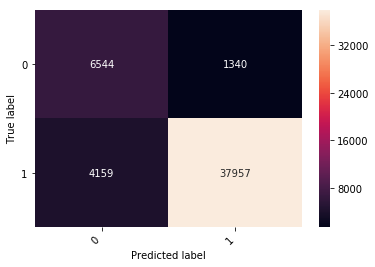

Bag of Words using GridSearch l1 regularization
****************************************************************************************************
Logistic Regression using GridSearchCV on Bag of Words  with Regularizer =  l2
The Best HyperParameter Value using  Bag of Words  and using  GridSearch is  1
Test Accuracy for Bag of Words using GridSearch  algorithm with C = 1  is  89.27
F1 score for Bag of Words using GridSearch  algorithm with C = 1  is  82.19
Recall for Bag of Words using GridSearch  agorithm with C = 1  is  86.78
Precision for Bag of Words using GridSearch  algorithm with C = 1  is  79.25

 Classification report for Bag of Words using GridSearch  algorithm with C = 1  is 
               precision    recall  f1-score   support

   Negative       0.62      0.83      0.71      7884
   Positive       0.97      0.90      0.93     42116

avg / total       0.91      0.89      0.90     50000

The Confusion Matrix for  Bag of Words using GridSearch  Algorithm


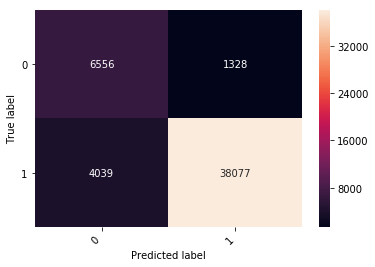

Bag of Words using GridSearch l2 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on Bag of Words  with Regularizer =  l1
The Best HyperParameter Value using  Bag of Words  and using  RandomSearch is  0.9063931076995756
Test Accuracy for Bag of Words using RandomSearch  algorithm with C = 0.9063931076995756  is  88.93
F1 score for Bag of Words using RandomSearch  algorithm with C = 0.9063931076995756  is  81.77
Recall for Bag of Words using RandomSearch  agorithm with C = 0.9063931076995756  is  86.63
Precision for Bag of Words using RandomSearch  algorithm with C = 0.9063931076995756  is  78.77

 Classification report for Bag of Words using RandomSearch  algorithm with C = 0.9063931076995756  is 
               precision    recall  f1-score   support

   Negative       0.61      0.83      0.70      7884
   Positive       0.97      0.90      0.93     42116

avg / total       0.91

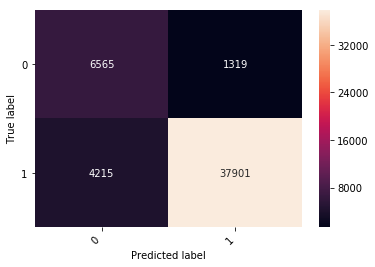

Bag of Words using RandomSearch l1 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on Bag of Words  with Regularizer =  l2
The Best HyperParameter Value using  Bag of Words  and using  RandomSearch is  0.3526644562950716
Test Accuracy for Bag of Words using RandomSearch  algorithm with C = 0.3526644562950716  is  89.18
F1 score for Bag of Words using RandomSearch  algorithm with C = 0.3526644562950716  is  82.23
Recall for Bag of Words using RandomSearch  agorithm with C = 0.3526644562950716  is  87.26
Precision for Bag of Words using RandomSearch  algorithm with C = 0.3526644562950716  is  79.14

 Classification report for Bag of Words using RandomSearch  algorithm with C = 0.3526644562950716  is 
               precision    recall  f1-score   support

   Negative       0.61      0.84      0.71      7884
   Positive       0.97      0.90      0.93     42116

avg / total       0.

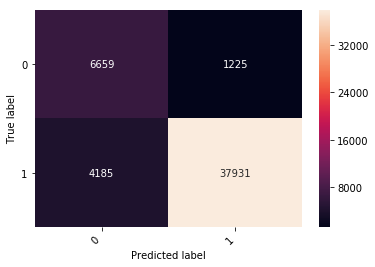

Bag of Words using RandomSearch l2 regularization
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


In [23]:
runLogisticRegression(X_Train_BOW,X_Test_BOW,y_train_BOW,y_test_BOW,'Bag of Words')


In [51]:
Final_Metrics.loc[:3,]

Algorithm                                      Vectorization  \
0  Logistic Regression    Bag of Words using GridSearch l1 regularization   
1  Logistic Regression    Bag of Words using GridSearch l2 regularization   
2  Logistic Regression  Bag of Words using RandomSearch l1 regularization   
3  Logistic Regression  Bag of Words using RandomSearch l2 regularization   

  HyperParameter  Training Accuracy Score  Testing Accuracy Score  F1 Score  \
0              1                    92.21                   89.00     81.83   
1              1                    92.83                   89.27     82.19   
2       0.906393                    92.08                   88.93     81.77   
3       0.352664                    91.84                   89.18     82.23   

   Precision Score  Recall Score  
0            78.87         86.56  
1            79.25         86.78  
2            78.77         86.63  
3            79.14         87.26

### Using TF-IDF

In [24]:
#Splitting into Training and Testing Set, and using only Training set for Word2Vec Training
X_Train_TFIDF,X_Test_TFIDF,y_train_TFIDF,y_test_TFIDF = train_test_split(final['CleanedText'],final['Score'])

In [25]:
# Using on TRain Dataset for fitting the TFIDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_Train_TFIDF = tf_idf_vect.fit_transform(X_Train_TFIDF.values)

# Using TRain fitted TFIDF to transform Test Dataset
tfidf_Test_TFIDF = tf_idf_vect.transform(X_Test_TFIDF.values)


#Check the structure of TFIDF transformed Train Dataset
print("the type of count vectorizer ",type(tfidf_Train_TFIDF))
print("the shape of out text TFIDF vectorizer ",tfidf_Train_TFIDF.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_Train_TFIDF.get_shape()[1])


#Check the structure of TFIDF transformed Test Dataset
print("the type of count vectorizer ",type(tfidf_Test_TFIDF))
print("the shape of out text TFIDF vectorizer ",tfidf_Test_TFIDF.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_Test_TFIDF.get_shape()[1])

X_train_Vectorised_TFIDF = tfidf_Train_TFIDF
X_test_Vectorised_TFIDF = tfidf_Test_TFIDF
X_train_Vectorised_TFIDF = np.nan_to_num(X_train_Vectorised_TFIDF)
X_test_Vectorised_TFIDF = np.nan_to_num(X_test_Vectorised_TFIDF)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (150000, 1686382)
the number of unique words including both unigrams and bigrams  1686382
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 1686382)
the number of unique words including both unigrams and bigrams  1686382


Logistic Regression using GridSearchCV on TF-IDF  with Regularizer =  l1
The Best HyperParameter Value using  TF-IDF  and using  GridSearch is  10000
Test Accuracy for TF-IDF using GridSearch  algorithm with C = 10000  is  92.77
F1 score for TF-IDF using GridSearch  algorithm with C = 10000  is  85.92
Recall for TF-IDF using GridSearch  agorithm with C = 10000  is  84.73
Precision for TF-IDF using GridSearch  algorithm with C = 10000  is  87.25

 Classification report for TF-IDF using GridSearch  algorithm with C = 10000  is 
               precision    recall  f1-score   support

   Negative       0.79      0.73      0.76      7886
   Positive       0.95      0.96      0.96     42114

avg / total       0.93      0.93      0.93     50000

The Confusion Matrix for  TF-IDF using GridSearch  Algorithm


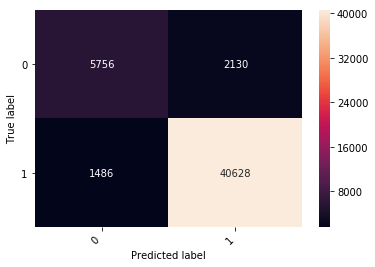

TF-IDF using GridSearch l1 regularization
****************************************************************************************************
Logistic Regression using GridSearchCV on TF-IDF  with Regularizer =  l2
The Best HyperParameter Value using  TF-IDF  and using  GridSearch is  100
Test Accuracy for TF-IDF using GridSearch  algorithm with C = 100  is  93.33
F1 score for TF-IDF using GridSearch  algorithm with C = 100  is  87.39
Recall for TF-IDF using GridSearch  agorithm with C = 100  is  87.18
Precision for TF-IDF using GridSearch  algorithm with C = 100  is  87.59

 Classification report for TF-IDF using GridSearch  algorithm with C = 100  is 
               precision    recall  f1-score   support

   Negative       0.79      0.78      0.79      7886
   Positive       0.96      0.96      0.96     42114

avg / total       0.93      0.93      0.93     50000

The Confusion Matrix for  TF-IDF using GridSearch  Algorithm


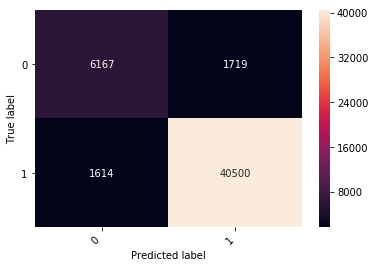

TF-IDF using GridSearch l2 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on TF-IDF  with Regularizer =  l1
The Best HyperParameter Value using  TF-IDF  and using  RandomSearch is  0.6140506410615916
Test Accuracy for TF-IDF using RandomSearch  algorithm with C = 0.6140506410615916  is  89.27
F1 score for TF-IDF using RandomSearch  algorithm with C = 0.6140506410615916  is  82.74
Recall for TF-IDF using RandomSearch  agorithm with C = 0.6140506410615916  is  88.77
Precision for TF-IDF using RandomSearch  algorithm with C = 0.6140506410615916  is  79.32

 Classification report for TF-IDF using RandomSearch  algorithm with C = 0.6140506410615916  is 
               precision    recall  f1-score   support

   Negative       0.61      0.88      0.72      7886
   Positive       0.98      0.89      0.93     42114

avg / total       0.92      0.89      0.90     50000

The Confusion Ma

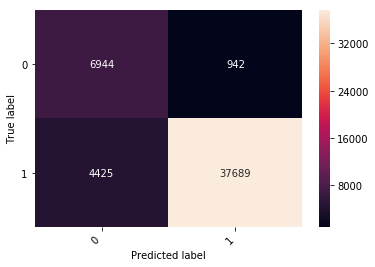

TF-IDF using RandomSearch l1 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on TF-IDF  with Regularizer =  l2
The Best HyperParameter Value using  TF-IDF  and using  RandomSearch is  0.8431300765544112
Test Accuracy for TF-IDF using RandomSearch  algorithm with C = 0.8431300765544112  is  90.95
F1 score for TF-IDF using RandomSearch  algorithm with C = 0.8431300765544112  is  84.72
Recall for TF-IDF using RandomSearch  agorithm with C = 0.8431300765544112  is  88.94
Precision for TF-IDF using RandomSearch  algorithm with C = 0.8431300765544112  is  81.84

 Classification report for TF-IDF using RandomSearch  algorithm with C = 0.8431300765544112  is 
               precision    recall  f1-score   support

   Negative       0.66      0.86      0.75      7886
   Positive       0.97      0.92      0.94     42114

avg / total       0.92      0.91      0.91     50000

The Confusion 

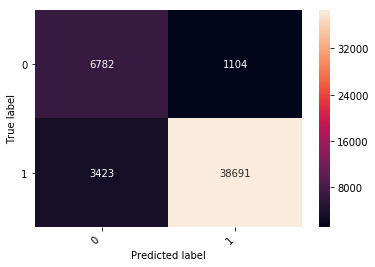

TF-IDF using RandomSearch l2 regularization
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


In [26]:
runLogisticRegression(X_train_Vectorised_TFIDF,X_test_Vectorised_TFIDF,y_train_TFIDF,y_test_TFIDF,'TF-IDF')

In [54]:
Final_Metrics.loc[4:7,]

Algorithm                                Vectorization  \
4  Logistic Regression    TF-IDF using GridSearch l1 regularization   
5  Logistic Regression    TF-IDF using GridSearch l2 regularization   
6  Logistic Regression  TF-IDF using RandomSearch l1 regularization   
7  Logistic Regression  TF-IDF using RandomSearch l2 regularization   

  HyperParameter  Training Accuracy Score  Testing Accuracy Score  F1 Score  \
4          10000                   100.00                   92.77     85.92   
5            100                   100.00                   93.33     87.39   
6       0.614051                    89.55                   89.27     82.74   
7        0.84313                    94.23                   90.95     84.72   

   Precision Score  Recall Score  
4            87.25         84.73  
5            87.59         87.18  
6            79.32         88.77  
7            81.84         88.94

    ### Using Average Word2Vec

In [27]:
#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_Train_AvgW2V,X_Test_AvgW2V,y_train_AvgW2V,y_test_AvgW2V = train_test_split(final['Text'],final['Score'])


# Train your own Word2Vec model using your own text corpus

i=0
list_of_sent=[]
for sent in X_Train_AvgW2V.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [28]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words = list(w2v_model.wv.vocab)
#print(len(words))

In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_Train_AvgW2V): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_train_Vectorised_AvgW2V = sent_vectors



sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_Test_AvgW2V): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_test_Vectorised_AvgW2V = sent_vectors
print(len(X_train_Vectorised_AvgW2V))
print(len(X_test_Vectorised_AvgW2V))


#np.where(np.isnan(X_test_Vectorised))
X_train_Vectorised_AvgW2V = np.nan_to_num(X_train_Vectorised_AvgW2V)
X_test_Vectorised_AvgW2V = np.nan_to_num(X_test_Vectorised_AvgW2V)
#np.nan_to_num(X_test_Vectorised)



100%|██████████| 50000/50000 [01:07<00:00, 740.59it/s]


150000
50000


Logistic Regression using GridSearchCV on Average Word2Vec  with Regularizer =  l1
The Best HyperParameter Value using  Average Word2Vec  and using  GridSearch is  1
Test Accuracy for Average Word2Vec using GridSearch  algorithm with C = 1  is  62.26
F1 score for Average Word2Vec using GridSearch  algorithm with C = 1  is  54.24
Recall for Average Word2Vec using GridSearch  agorithm with C = 1  is  63.18
Precision for Average Word2Vec using GridSearch  algorithm with C = 1  is  57.19

 Classification report for Average Word2Vec using GridSearch  algorithm with C = 1  is 
               precision    recall  f1-score   support

   Negative       0.24      0.65      0.35      7904
   Positive       0.90      0.62      0.73     42096

avg / total       0.80      0.62      0.67     50000

The Confusion Matrix for  Average Word2Vec using GridSearch  Algorithm


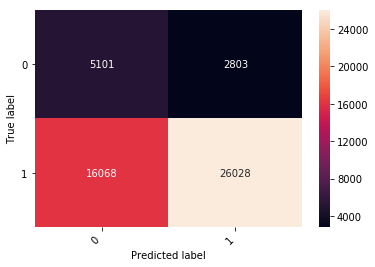

Average Word2Vec using GridSearch l1 regularization
****************************************************************************************************
Logistic Regression using GridSearchCV on Average Word2Vec  with Regularizer =  l2
The Best HyperParameter Value using  Average Word2Vec  and using  GridSearch is  1
Test Accuracy for Average Word2Vec using GridSearch  algorithm with C = 1  is  62.65
F1 score for Average Word2Vec using GridSearch  algorithm with C = 1  is  54.39
Recall for Average Word2Vec using GridSearch  agorithm with C = 1  is  63.03
Precision for Average Word2Vec using GridSearch  algorithm with C = 1  is  57.13

 Classification report for Average Word2Vec using GridSearch  algorithm with C = 1  is 
               precision    recall  f1-score   support

   Negative       0.24      0.64      0.35      7904
   Positive       0.90      0.62      0.74     42096

avg / total       0.80      0.63      0.68     50000

The Confusion Matrix for  Average Word2Vec using Gri

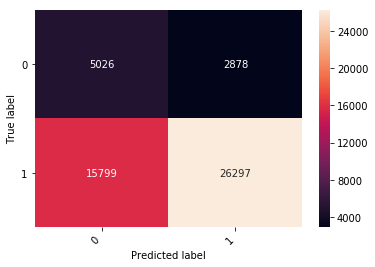

Average Word2Vec using GridSearch l2 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on Average Word2Vec  with Regularizer =  l1
The Best HyperParameter Value using  Average Word2Vec  and using  RandomSearch is  0.3725361838849832
Test Accuracy for Average Word2Vec using RandomSearch  algorithm with C = 0.3725361838849832  is  62.24
F1 score for Average Word2Vec using RandomSearch  algorithm with C = 0.3725361838849832  is  54.15
Recall for Average Word2Vec using RandomSearch  agorithm with C = 0.3725361838849832  is  62.97
Precision for Average Word2Vec using RandomSearch  algorithm with C = 0.3725361838849832  is  57.08

 Classification report for Average Word2Vec using RandomSearch  algorithm with C = 0.3725361838849832  is 
               precision    recall  f1-score   support

   Negative       0.24      0.64      0.35      7904
   Positive       0.90      0.62      0.73  

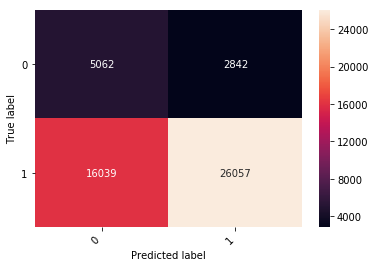

Average Word2Vec using RandomSearch l1 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on Average Word2Vec  with Regularizer =  l2
The Best HyperParameter Value using  Average Word2Vec  and using  RandomSearch is  0.7586490169898722
Test Accuracy for Average Word2Vec using RandomSearch  algorithm with C = 0.7586490169898722  is  62.66
F1 score for Average Word2Vec using RandomSearch  algorithm with C = 0.7586490169898722  is  54.39
Recall for Average Word2Vec using RandomSearch  agorithm with C = 0.7586490169898722  is  63.02
Precision for Average Word2Vec using RandomSearch  algorithm with C = 0.7586490169898722  is  57.13

 Classification report for Average Word2Vec using RandomSearch  algorithm with C = 0.7586490169898722  is 
               precision    recall  f1-score   support

   Negative       0.24      0.64      0.35      7904
   Positive       0.90      0.62      0.74

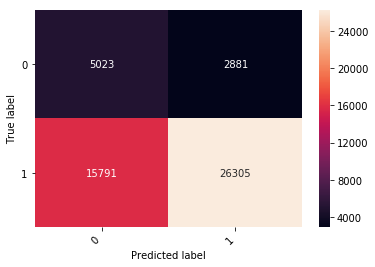

Average Word2Vec using RandomSearch l2 regularization
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


In [30]:
runLogisticRegression(X_train_Vectorised_AvgW2V,X_test_Vectorised_AvgW2V,y_train_AvgW2V,y_test_AvgW2V,'Average Word2Vec')

In [55]:
Final_Metrics.loc[8:11,]

Algorithm                                      Vectorization  \
8   Logistic Regression  Average Word2Vec using GridSearch l1 regulariz...   
9   Logistic Regression  Average Word2Vec using GridSearch l2 regulariz...   
10  Logistic Regression  Average Word2Vec using RandomSearch l1 regular...   
11  Logistic Regression  Average Word2Vec using RandomSearch l2 regular...   

   HyperParameter  Training Accuracy Score  Testing Accuracy Score  F1 Score  \
8               1                    62.42                   62.26     54.24   
9               1                    62.77                   62.65     54.39   
10       0.372536                    62.42                   62.24     54.15   
11       0.758649                    62.73                   62.66     54.39   

    Precision Score  Recall Score  
8             57.19         63.18  
9             57.13         63.03  
10            57.08         62.97  
11            57.13         63.02

### Using TF-IDF Weighted Word2Vec

In [31]:
#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_Train_TFIDFW2V,X_Test_TFIDFW2V,y_train_TFIDFW2V,y_test_TFIDFW2V = train_test_split(final['CleanedText'],final['Score'])

# TF-IDF weighted Word2Vec
vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_Train_TFIDFW2V)
tfidf_feat = vect_tfidf.get_feature_names() # tfidf words/col-names
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_feat, list(vect_tfidf.idf_)))
#print(tfidf_feat)
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_Train_TFIDFW2V): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train_Vectorised_TFIDFW2V = tfidf_sent_vectors


tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_Test_TFIDFW2V): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
#           tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1



X_test_Vectorised_TFIDFW2V = tfidf_sent_vectors
    
X_train_Vectorise_TFIDFW2Vd = np.nan_to_num(X_train_Vectorised_TFIDFW2V)
X_test_Vectorised_TFIDFW2V = np.nan_to_num(X_test_Vectorised_TFIDFW2V)

100%|██████████| 50000/50000 [00:36<00:00, 1362.11it/s]


Logistic Regression using GridSearchCV on TF-IDF Weighted Word2Vec  with Regularizer =  l1
The Best HyperParameter Value using  TF-IDF Weighted Word2Vec  and using  GridSearch is  0.0001
Test Accuracy for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.0001  is  16.09
F1 score for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.0001  is  13.86
Recall for TF-IDF Weighted Word2Vec using GridSearch  agorithm with C = 0.0001  is  50.0
Precision for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.0001  is  8.04

 Classification report for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.0001  is 
               precision    recall  f1-score   support

   Negative       0.16      1.00      0.28      8044
   Positive       0.00      0.00      0.00     41956

avg / total       0.03      0.16      0.04     50000

The Confusion Matrix for  TF-IDF Weighted Word2Vec using GridSearch  Algorithm


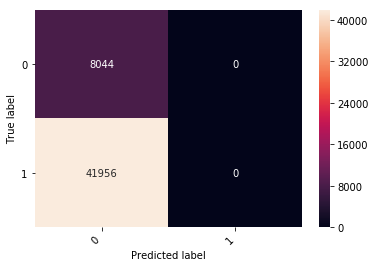

TF-IDF Weighted Word2Vec using GridSearch l1 regularization
****************************************************************************************************
Logistic Regression using GridSearchCV on TF-IDF Weighted Word2Vec  with Regularizer =  l2
The Best HyperParameter Value using  TF-IDF Weighted Word2Vec  and using  GridSearch is  0.01
Test Accuracy for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.01  is  16.09
F1 score for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.01  is  13.86
Recall for TF-IDF Weighted Word2Vec using GridSearch  agorithm with C = 0.01  is  50.0
Precision for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.01  is  8.04

 Classification report for TF-IDF Weighted Word2Vec using GridSearch  algorithm with C = 0.01  is 
               precision    recall  f1-score   support

   Negative       0.16      1.00      0.28      8044
   Positive       0.00      0.00      0.00     41956

avg / total       0.03    

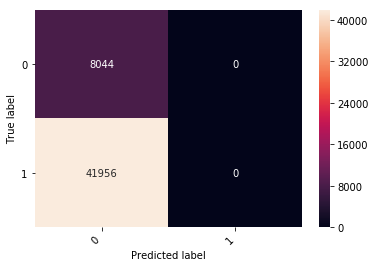

TF-IDF Weighted Word2Vec using GridSearch l2 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on TF-IDF Weighted Word2Vec  with Regularizer =  l1
The Best HyperParameter Value using  TF-IDF Weighted Word2Vec  and using  RandomSearch is  0.1044115687484447
Test Accuracy for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.1044115687484447  is  16.09
F1 score for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.1044115687484447  is  13.86
Recall for TF-IDF Weighted Word2Vec using RandomSearch  agorithm with C = 0.1044115687484447  is  50.0
Precision for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.1044115687484447  is  8.04

 Classification report for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.1044115687484447  is 
               precision    recall  f1-score   support

   Negative       0.16      1.00   

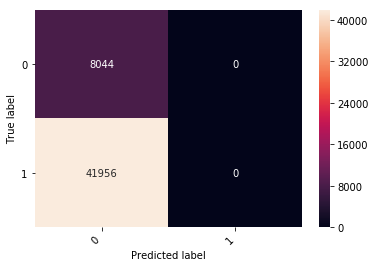

TF-IDF Weighted Word2Vec using RandomSearch l1 regularization
****************************************************************************************************
Logistic Regression using RandomSearchCV on TF-IDF Weighted Word2Vec  with Regularizer =  l2
The Best HyperParameter Value using  TF-IDF Weighted Word2Vec  and using  RandomSearch is  0.7472792181956972
Test Accuracy for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.7472792181956972  is  16.09
F1 score for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.7472792181956972  is  13.86
Recall for TF-IDF Weighted Word2Vec using RandomSearch  agorithm with C = 0.7472792181956972  is  50.0
Precision for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.7472792181956972  is  8.04

 Classification report for TF-IDF Weighted Word2Vec using RandomSearch  algorithm with C = 0.7472792181956972  is 
               precision    recall  f1-score   support

   Negative       0.16      1.00 

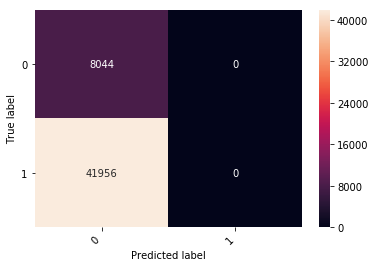

TF-IDF Weighted Word2Vec using RandomSearch l2 regularization
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


In [32]:
runLogisticRegression(X_train_Vectorised_TFIDFW2V,X_test_Vectorised_TFIDFW2V,y_train_TFIDFW2V,y_test_TFIDFW2V,'TF-IDF Weighted Word2Vec')

In [56]:
Final_Metrics.loc[12:15,]

Algorithm                                      Vectorization  \
12  Logistic Regression  TF-IDF Weighted Word2Vec using GridSearch l1 r...   
13  Logistic Regression  TF-IDF Weighted Word2Vec using GridSearch l2 r...   
14  Logistic Regression  TF-IDF Weighted Word2Vec using RandomSearch l1...   
15  Logistic Regression  TF-IDF Weighted Word2Vec using RandomSearch l2...   

   HyperParameter  Training Accuracy Score  Testing Accuracy Score  F1 Score  \
12         0.0001                    15.75                   16.09     13.86   
13           0.01                    15.75                   16.09     13.86   
14       0.104412                    15.75                   16.09     13.86   
15       0.747279                    15.75                   16.09     13.86   

    Precision Score  Recall Score  
12             8.04          50.0  
13             8.04          50.0  
14             8.04          50.0  
15             8.04          50.0

### Conclusion


In [33]:
Final_Metrics

Algorithm                                      Vectorization  \
0   Logistic Regression    Bag of Words using GridSearch l1 regularization   
1   Logistic Regression    Bag of Words using GridSearch l2 regularization   
2   Logistic Regression  Bag of Words using RandomSearch l1 regularization   
3   Logistic Regression  Bag of Words using RandomSearch l2 regularization   
4   Logistic Regression          TF-IDF using GridSearch l1 regularization   
5   Logistic Regression          TF-IDF using GridSearch l2 regularization   
6   Logistic Regression        TF-IDF using RandomSearch l1 regularization   
7   Logistic Regression        TF-IDF using RandomSearch l2 regularization   
8   Logistic Regression  Average Word2Vec using GridSearch l1 regulariz...   
9   Logistic Regression  Average Word2Vec using GridSearch l2 regulariz...   
10  Logistic Regression  Average Word2Vec using RandomSearch l1 regular...   
11  Logistic Regression  Average Word2Vec using RandomSearch l2 regular...   
12  Logistic Regression  TF-IDF Weighted Word2Vec using GridSearch l1 r...   
13  Logistic Regression  TF-IDF Weighted Word2Vec using GridSearch l2 r...   
14  Logistic Regression  TF-IDF Weighted Word2Vec using RandomSearch l1...   
15  Logistic Regression  TF-IDF Weighted Word2Vec using RandomSearch l2...   

   HyperParameter  Training Accuracy Score  Testing Accuracy Score  F1 Score  \
0               1                    92.21                   89.00     81.83   
1               1                    92.83                   89.27     82.19   
2        0.906393                    92.08                   88.93     81.77   
3        0.352664                    91.84                   89.18     82.23   
4           10000                   100.00                   92.77     85.92   
5             100                   100.00                   93.33     87.39   
6        0.614051                    89.55                   89.27     82.74   
7         0.84313                    94.23                   90.95     84.72   
8               1                    62.42                   62.26     54.24   
9               1                    62.77                   62.65     54.39   
10       0.372536                    62.42                   62.24     54.15   
11       0.758649                    62.73                   62.66     54.39   
12         0.0001                    15.75                   16.09     13.86   
13           0.01                    15.75                   16.09     13.86   
14       0.104412                    15.75                   16.09     13.86   
15       0.747279                    15.75                   16.09     13.86   

    Precision Score  Recall Score  
0             78.87         86.56  
1             79.25         86.78  
2             78.77         86.63  
3             79.14         87.26  
4             87.25         84.73  
5             87.59         87.18  
6             79.32         88.77  
7             81.84         88.94  
8             57.19         63.18  
9             57.13         63.03  
10            57.08         62.97  
11            57.13         63.02  
12             8.04         50.00  
13             8.04         50.00  
14             8.04         50.00  
15             8.04         50.00

#### The Above table shows that Logistic Regression run using TF-IDF using GridSearch L2 Regularization results in the highest Testing Accuracy of 93.33%  with a C-value of 100.

### Sparsity and Multicollinearity Check

In [34]:
# Report Error and Sparsity with increasing Alpha value using L1 regularizer 

def reportSparsity(X_Train,X_Test,Y_Train,Y_Test,C1,C2):

    # Increase in Sparsity with increase in Alpha Value(decrease in C Value)
    logistic = LogisticRegression(C= C1, penalty= 'l1',n_jobs = -2)
    logistic.fit(X_Train,Y_Train)
    pred = logistic.predict(X_Test)
    print("Test Accuracy on C=1000: %0.4f%%"%(accuracy_score(Y_Test, pred)*100))
    print("Non Zero weights:",np.count_nonzero(logistic.coef_))


    logistic = LogisticRegression(C= C2, penalty= 'l1',n_jobs = -2)
    logistic.fit(X_Train,Y_Train)
    pred = logistic.predict(X_Test)
    print("Test Accuracy on C=100: %0.4f%%"%(accuracy_score(Y_Test, pred)*100))
    print("Non Zero weights:",np.count_nonzero(logistic.coef_))

In [35]:
reportSparsity(X_Train_BOW,X_Test_BOW,y_train_BOW,y_test_BOW,C1 = 1000,C2 = 100)






Test Accuracy on C=1000: 89.3240%
Non Zero weights: 29866
Test Accuracy on C=100: 89.8840%
Non Zero weights: 24686


In [36]:
reportSparsity(X_train_Vectorised_TFIDF,X_test_Vectorised_TFIDF,y_train_TFIDF,y_test_TFIDF,C1 =10000,C2 = 1000)







Test Accuracy on C=1000: 92.6360%
Non Zero weights: 101779
Test Accuracy on C=100: 92.6880%
Non Zero weights: 40178


#### From the above results we can see that Sparsity INCREASES with the increase in C-Value

### Perturbation Test and Elbow Method to identify optimum Threshold

In [37]:
#Perturbation Test to check Multicollinearity

# Function to add check change of weights after adding noise and then plot the elbow graph to derieve the threshold
def perturbationTest (X_Train,X_Test,y_train,y_test):
    
    #Weights before adding noise
    X_train1_beforeNoise = X_Train
    X_test1_beforeNoise = X_Test
    y_train1_beforeNoise =y_train
    y_test1_beforeNoise = y_test
    logistics = LogisticRegression(C= 5, penalty= 'l2',n_jobs = -1)
    logistics.fit(X_train1_beforeNoise,y_train1_beforeNoise)
    beforeWeight = logistics.coef_
    # print(beforeWeight.shape[1])
    
    #After adding Noise
    X_train2_afterNoise = X_Train
    X_test2_afterNoise = X_Test
    y_train2_afterNoise =y_train
    y_test2_afterNoise = y_test
    #print(X_train2_afterNoise.shape[1])
    #adding Noise using uniform Random Distribution
    epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(X_train2_afterNoise.shape[1]))
    #print(epsilon.shape)
    #print(type(epsilon))
    #print(type(X_train2_afterNoise.data))
    X_train2_afterNoise.data = X_train2_afterNoise.data + 0.001
    #print(X_train2.shape)
    logistics1 = LogisticRegression(C= 5, penalty= 'l2',n_jobs = -1)
    logistics1.fit(X_train2_afterNoise,y_train2_afterNoise)
    afterWeight = logistics1.coef_
    # print(afterWeight.shape[1])
    
    
    # Getting the difference in weights before and after adding noise
    weights_diff = ((abs(beforeWeight - afterWeight)) / abs(beforeWeight)) * 100
    
    weights_diff = ((abs(beforeWeight - afterWeight)) / abs(beforeWeight)) * 100
    # print(weights_diff[0])
    # print(weights_diff.min())
    # print(weights_diff.min())
    
    #getting the feature names and zipping them together with the afterNoise Weights and Weight Difference
    feature_names = vect.get_feature_names()
    weightsWithFeatures = zip(afterWeight,weights_diff,feature_names)

    # Creating the plot to understand the optimum threshold to take
    # tmp=[sum([1 for threshold in np.linspace(0,1,num=10) if j<threshold]) for i,j,k in zip(afterWeight[0],weights_diff[0],feature_names) ]
    for_elbow = []
    for each in np.linspace(0,1,num=100):
        temp_num =0
        for i,j,k in zip(afterWeight[0],weights_diff[0],feature_names):
            if j>each:
                temp_num+=1
        for_elbow.append(temp_num)


    plt.plot(np.linspace(0,1,num=100),for_elbow)
    plt.xlabel("Threshold")
    plt.ylabel('No. of Features')
    plt.show()
    
    return [afterWeight,weights_diff,feature_names]

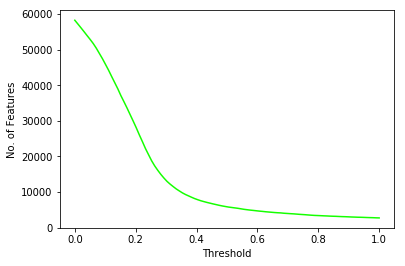

In [38]:
weightVector = perturbationTest(X_Train_BOW,X_Test_BOW,y_train_BOW,y_test_BOW)


afterWeight = weightVector[0][0]
weight_diff = weightVector[1][0]
feature_names = weightVector[2]


#### From the above graph, the elbow is considered as 0.35

In [46]:
#( ((|W-W'|+100) / (W+100))*100)
# print("The %tage change in Weights after adding Noise :" , weights_diff)
print("\t\t\tFeature Name\t\t\t\t\tWeight Difference")
for i,j,k in zip(afterWeight,weight_diff,feature_names):
    
    if j>0.35:
        print("\t\t\t{0}\t\t\t\t\t\t{1}".format(k,j))
        


			Feature Name					Weight Difference
			aaa						1.3392615994309367
			aaaaaaahhhhhh						1.5682253295113004
			aaaaaaarrrrrggghhh						1.0272260552465635
			aaaaaahhhhhyaaaaaa						1.8415629779897635
			aaaaaawwwwwwwwww						1.8263122295431853
			aaaahhhhhh						1.8263122295431853
			aaah						1.8263122295431853
			aaahhh						1.8263122295431853
			aabout						1.1649622341400374
			aachen						1.1649622341400374
			aacur						1.0247772977283849
			aadp						1.0247772977283849
			aadult						1.057444430295208
			aaf						1.057444430295208
			aafco						2.2128073570059867
			aagreen						2.2128073570059867
			aah						2.123589570900591
			aahh						3.725821459372299
			aahhh						1.1276919934611862
			aamazon						3.6864196323264826
			aana						1.2545194382127194
			aand						1.7451820228320893
			aanoth						0.3897721748713365
			aap						1.7473907634175607
			aappubl						0.7351061048401736
			aar						2.3738494473314975
			aarthur						1.3165374015778852
			aasanfood						1.3165374

			aveda						0.6911674611991272
			avelinden						0.6447854577808811
			avent						2.3109246658614953
			aventinus						1.2090627668853018
			aventius						1.11476797733492
			avenu						1.732770706000657
			avenuepompano						1.4259159209138517
			avenuesweet						0.38944281253923385
			avenunu						1.438043512014572
			aver						0.5629638316859392
			averag						2.0387860445301285
			avergag						0.8191112190093158
			averi						4.26431536896669
			avers						5.032188244949285
			avert						5.286474451626206
			avg						1.4552497816316017
			avial						0.9629458645656308
			avian						0.6910490567274102
			aviat						0.4851074307629729
			avid						0.4402640812723317
			avil						1.913057482563113
			avili						3.4832607896614873
			avion						1.2210519797875987
			avita						1.5215869817955978
			avitamin						3.3409073320089555
			avocado						5.921221257393819
			avodart						3.2106050023421795
			avoderm						2.047645095442671
			avodern						2.4814503116552835
			avoid						0.6

			breast						0.5129221006355626
			breastfeed						0.7248307442671277
			breastfin						1.5546726669310558
			breastfortifi						1.2323288946996271
			breastmilk						1.438043512014572
			breastson						1.7004928904308918
			breat						0.3595075116190232
			breatfeed						3.507342697690543
			breathabl						0.7689103124421298
			breathalyz						0.4723760767541752
			breathi						1.0771239112010766
			breathless						0.41247283868456797
			breathlessid						4.9371315303527865
			breathsalt						3.0755564968555653
			breathtak						0.3937307184117977
			breaux						1.0189931438701065
			bred						1.8622809813107049
			breed						1.9651231841851242
			breeder						3.205441641044161
			breen						3.965182724519579
			breez						5.900345258121523
			breeza						1.9863174106125738
			breezer						2.849938385153435
			breezi						5.679183541880522
			breitsam						1.1853767646743194
			breitsamm						1.8671635477128246
			brejla						1.7440203321478511
			brekfast						1.8258128802985714
		

			cheeselov						0.3769082651846974
			cheesemak						2.091608226419048
			cheeseman						1.138835701049091
			cheesemustard						6.4491821179397375
			cheeseno						2.425313888326179
			cheeseoh						2.410444765027977
			cheeseorwisconsinmad						3.173904458183674
			cheeseramien						1.892429699749388
			cheeseslav						0.4189359599601878
			cheesesteak						0.6913543606720198
			cheesestri						0.8183674423213376
			cheeseth						4.839920052531522
			cheesethi						0.5951061826844559
			cheesew						0.36320760859164175
			cheesewhich						3.716081244332603
			cheesey						0.8627160607152561
			cheesi						0.9734712511863124
			cheesier						0.49631198979073077
			cheesless						3.8475592352788537
			cheessi						1.6189467534904838
			cheesywith						2.435282028022179
			cheetah						0.5880581142101426
			cheeto						2.2757543937581617
			cheetoh						4.028348319827489
			cheetosi						19.206057669975863
			cheetra						0.8967261983097725
			cheez						2.5243693607903506
			cheezi		

			corrug						4.9236654271222795
			corrupt						1.786129637348614
			corsag						0.4592352705365387
			corsicana						0.957841334020345
			corso						7.9107749373418565
			corsorzio						0.7921311858962299
			corta						5.459062799518484
			cortes						3.131815456130227
			cortez						2.5389093389890016
			cortisol						3.176872722902961
			corto						3.303708982230798
			corylus						0.5003821364387036
			cosa						0.8529233903149593
			cosequin						2.594685140562323
			cosi						0.48369126972009
			cosmic						3.122968653759596
			cosmopolitan						2.9567124570182597
			cosmopolitani						13.73691610747617
			cosmos						2.711296428890547
			cost						2.298167960103588
			costa						2.434181460760611
			costal						0.7403952611424797
			costand						0.9113150072215878
			costanza						1.7771360096927487
			costarica						2.9071679058067827
			costco						2.4414543763798027
			costcoand						1.5104855454779915
			costcoif						0.5676930896013602
			costdo						0.3679621177071407
		

			deprav						1.7097674496369286
			depress						1.4850643485879367
			depression						4.292760721993845
			depressor						3.2354255129516547
			depresss						1.8643330738570183
			depriev						3.4083843582635063
			depriv						0.7256461637542803
			depsit						0.40300537866573016
			dept						2.024036045581824
			deptford						2.509861434214306
			depth						0.5945769469359737
			depui						2.742577628017069
			deputi						0.7891942782389728
			der						0.7413825654131584
			derail						1.0072612104622
			deramaxx						0.9773810402647428
			derang						4.793805486682126
			derbi						0.8259532887150389
			derect						1.724693212121468
			deregul						1.4155335110671734
			deridd						6.599067087986003
			deris						2.8968993933973803
			deriv						5.41951560388877
			derivit						0.6120761445157762
			dermat						0.6514633150030597
			dermo						2.526201583170447
			dern						1.2208598727620716
			dernit						1.0511579868388603
			derrick						1.3660315256153608
			derrier						0.489

			dylabon						2.221408437827733
			dylan						3.611313853611647
			dynam						2.348628321186197
			dynamit						0.6302629472177139
			dynamo						0.8469655473339157
			dynapep						0.5683124805324006
			dyno						1.7955333329485859
			dynomit						0.42574142890656186
			dyschezia						0.5127676719434192
			dysfunct						2.663800095430347
			dyslect						5.551892001318535
			dyslipidemia						1.2257911851952383
			dyspepsia						1.663150753859681
			dysplsia						1.1548968723337467
			ea						2.9115970066532646
			eabuy						1.3224998811706965
			eacg						0.9156050465120769
			eachexcel						2.4868242606459012
			eachfound						0.7785997595511452
			eachhimalaya						2.71200656812766
			eachi						2.8679823738119707
			eachoth						3.731707013479215
			eachrow						0.7156536458334574
			eachso						1.3448005940386243
			eachthi						2.8194395745921854
			ead						2.6686542464541523
			eadh						0.9293648099881343
			eag						0.574152413405845
			eager						0.8594692045400913
			eagl	

			favoritegreat						0.42223709534497406
			favoritegreen						0.36539108311101076
			favoritei						2.9566365485600756
			favoritelif						0.35874075856063625
			favoriteomg						0.4055842526023468
			favoritesa						2.5348825341590375
			favoritesalmon						5.8594260607161015
			favoritesi						4.0630176009679095
			favoritesinc						1.6082436398150237
			favoritesnic						2.1799257556062277
			favoriteth						4.967053348868327
			favoritethes						0.5828062032993572
			favoritethey						0.6126046368959828
			favoritetofu						1.0651093121513937
			favoritew						2.0407611025731858
			favoritewel						2.9447361879308276
			favorito						1.274209752578447
			favorti						2.4060728892055816
			favortiresi						1.849979737168005
			favour						1.7793347727027828
			favourit						0.9611263336940343
			fawourit						0.8479436503146363
			fax						2.886995376599846
			fay						1.5833029359864765
			faygo						1.000539276002455
			fazermint						2.1885008501638143
			fbd						1.11230516692

			good						1.3580830612967567
			gooda						0.9262702214508995
			goodad						0.5097077596592304
			goodal						3.51915595003705
			goodalso						0.4203424869711676
			goodamazon						0.4210575117947314
			goodand						2.0302625632639497
			goodat						2.3628381156453915
			goodbar						3.843221245553442
			goodberrymint						1.065498290587749
			goodby						4.192951917243288
			goodbyejust						1.3714502259057988
			goodcan						1.245224709933203
			goodcancel						1.781225198863571
			goodcelesti						0.4168719987444754
			goodcondit						2.097136310255956
			goodcontain						0.7734759382327488
			goodcup						0.4631532288655535
			gooddark						1.4873346154394878
			goodeven						0.444361233352488
			goodfor						3.5864930580282963
			goodfyi						2.359303185781198
			goodgood						0.5528246312263532
			goodgreat						3.1369959773089735
			goodhigh						0.5276635098546424
			goodhot						3.7616093918196003
			goodiesnot						2.3343376188068534
			goodigood						2.2875572426499717


			hyperplasia						0.44281099608023033
			hypersensit						0.7565805721105893
			hypersweet						0.5190957627360472
			hypertens						0.7191718361159063
			hypertent						2.6529911332206937
			hyperthyroid						0.7607938383925402
			hypertriglyceridemia						1.535397086826393
			hypervitaminosi						0.5277056074928972
			hyphen						0.3896799274093586
			hypnagog						1.6299399611140175
			hypnosi						2.302543858206498
			hypnot						0.7128295456108409
			hypo						2.2034826243985486
			hypoallergen						2.8334457322115782
			hypoallergi						3.1198998132124576
			hypocrit						0.8039714693041733
			hypoderm						1.7112786822782007
			hypoglecemia						0.4632912780934602
			hypoglycem						1.747833532426295
			hypoglycemia						2.682476616989865
			hypoglycemnia						0.5759232957784052
			hypogycem						0.5035494964572719
			hypogycemia						0.8817838974600798
			hypokalemia						2.886203445708866
			hypomag						0.5235160565803664
			hypothalamus						0.8599678226998706
			hypothes	

			kristen						1.6959350371791533
			kristensraw						1.6959350371791533
			kristin						0.9511830605350139
			kroenung						0.713811622984937
			kronch						0.42139615140511555
			kronung						1.843389763747566
			krospol						1.0554524684816822
			krueg						0.7312888224815562
			krueng						0.6533034820483664
			kruig						2.1850662476218266
			krunch						2.2677613565827164
			kruncher						0.7012623642961483
			krunchi						0.4114270494999463
			krup						1.6818544560516857
			krupa						0.6656433238525292
			krupsgrind						0.974571413555846
			krusteaz						0.7190768529526685
			krusteez						1.9049443502768448
			krustz						4.747075086301467
			kruteaz						0.8294928339273305
			kryptonit						1.191348367738065
			ksar						2.1735737985036843
			ksino						0.8485208431106431
			ktc						1.1771520926260548
			kthxbai						2.135088756942988
			ktla						2.7297192002955737
			ktti						0.8173841088675962
			kuchela						1.9603351967271654
			kuchen						3.900664983673121
			kuch

			mementa						0.9407122512999555
			memento						1.6599509831366999
			memer						1.4907962072987555
			memmi						7.606053366679875
			memo						2.1858014511407595
			memorabilia						0.6754772324907192
			memorex						1.271795504165322
			memoriesth						0.7877617401470532
			memorieswhen						1.6571514663855587
			memoryfor						0.5343379000254721
			men						1.316343709837166
			mena						0.43280623387929207
			menac						2.2302587105630662
			menadan						3.049484248480367
			menadion						0.5509960641295082
			menard						0.6532471558487044
			menchan						2.589778477070425
			mend						0.7753448820099788
			mendadion						1.1246754456381098
			mendaion						2.1514641541740733
			mendocino						1.6916676942864282
			mendoza						4.286520462287195
			menedion						0.7695217052220358
			mengo						1.2754780785252209
			menhaden						0.7854320352101364
			meni						1.000539276002455
			menial						2.71219728322291
			meniton						0.9695957770063341
			menlo						2.55954265176954
	

			nugat						0.4976233363799413
			nugent						3.3733768576347196
			nuget						1.1652942857850668
			nuggest						1.7077036895127629
			nugget						2.6532170993549626
			nuggeti						1.7611425381448216
			nuggett						1.1046615858365711
			nugo						0.9181935322364294
			nuhz						0.6913543606720198
			nui						2.7227740855539833
			nuisonc						2.2868888517080412
			nuker						1.5493115013534047
			null						7.800393659148409
			nullifi						1.986579047078792
			num						1.6422907198779158
			number						1.6803205381523214
			numberof						2.3453470934492393
			numer						0.8034790802639534
			numero						0.4275815049313477
			numi						0.6411040312747154
			numirus						3.5079822067832342
			nummi						0.7855742718688709
			nummsi						1.1754006942200377
			numthi						8.773211877798305
			nune						0.9127684178555114
			nunez						0.4695310230011967
			nur						1.0653368005362156
			nurich						0.49814477573779303
			nurit						0.3707773274578965
			nurs						2.7120452386782183
		

			peic						1.8725264270458402
			peicer						0.9321222146481867
			peiffer						0.4540546146491743
			peiod						1.6331081070912745
			pejor						2.5016620810016534
			pek						1.463230152996494
			peke						2.333378191555567
			pekin						5.339084179579231
			pekines						5.339084179579231
			pekmez						5.359064216976432
			peko						1.9708756788841788
			pel						0.3934162280682817
			pelican						2.6982633694499727
			pelicanbay						2.631059331211304
			pelindaba						0.402121827396306
			pellegrino						0.8014617408429908
			pellet						0.5094433530925909
			pelletsno						5.359064216976432
			pellicl						8.081997705653878
			pelligrino						8.081997705653878
			peloponnes						0.8219259374284413
			pelt						1.6871565419792751
			pemberton						0.7541289124387786
			pembrok						0.7987125453258063
			pemican						0.7137021961109655
			pemium						0.5271175064971397
			pemmican						1.876037496819746
			pen						0.38113770449108786
			penal						1.5020430736327663
			penalti		

			putuo						2.568400561717863
			puur						0.4473198867744373
			puurfect						3.4168155176627697
			puuurr						0.7949562368024531
			puuuuuff						1.4722976585945449
			puuuuuuff						0.6499544747422703
			puver						5.00902462455988
			puy						3.412803131763305
			puzzel						1.9061153165876275
			puzzl						4.2844107867838055
			pvcs						0.443643150592431
			pvd						1.4887349811489914
			pwdr						2.2432707457576964
			pwo						0.7744301981080813
			pwopewli						1.4074498550790278
			pybrief						0.7304448384540853
			pyekki						2.0895938983949613
			pyewacket						0.40830076660723863
			pygmi						0.6043911979593937
			pyoderma						0.5616920269062798
			pyr						1.015067607782422
			pyramid						0.5523730441028988
			pyrane						1.6148332001891819
			pyre						1.091517586597265
			pyrene						1.780381176269509
			pyrenn						0.9960819850503314
			pyrex						2.160805735669395
			pyridin						0.6000542608527869
			pyrithion						0.6151769695037926
			pyrmethrin						0.412567

			sainsburi						0.6036902718421648
			saint						0.9430095262555566
			saintsit						1.4703664113444492
			saison						0.6803418560994499
			saki						0.4322221351994612
			sakura						0.35374214990748665
			sal						0.5974648447311582
			salad						2.657326837983848
			salada						0.4872521491935812
			saladdefinit						0.6131070157521212
			saladpotato						0.8476801705590138
			saladsaladveggi						3.049181511211812
			saladwith						2.7502470398923657
			salam						0.8835923438280879
			salamand						0.3710917273273909
			salamandra						2.8071236837000786
			salami						0.8797501069773925
			salari						0.8797501069773925
			salat						0.9909573252903715
			salatkroenung						2.739160705273914
			salavador						0.7605850838571787
			salbathat						0.6648320840009295
			salcha						2.055370638125237
			salda						0.6719846553787747
			saleabl						4.151975666437799
			salecannot						4.56307061201165
			salecompar						0.675873614273453
			saleit						0.7903972466258995
			saleiv

			shoulkd						1.7932772881693508
			shoulnt						0.3545914378765509
			shout						0.6268917768194693
			shouw						1.0401583025337033
			shove						0.6097318888596479
			shovel						4.921093310476698
			show						1.4215662149521604
			showdown						0.46203007837544796
			shower						0.8695171424714069
			showi						0.6268917768194693
			shown						0.765079958197648
			showr						4.509156437198873
			showstopp						1.0390453813894414
			shoya						0.3881489454032751
			shoyu						1.0423385306441841
			shrank						6.472082388768417
			shrapnel						2.3928856752468506
			shread						2.3928856752468506
			shredder						3.0527084979998906
			shrede						0.9902174666527443
			shredless						2.8902168857135093
			shreveport						0.5832399797645524
			shrewd						4.604730486616556
			shrimp						0.7750467006511845
			shrimpi						0.7750467006511845
			shrinkag						0.3811473830598521
			shrinkwrap						1.006696878455486
			shrivel						1.6796391082558169
			shrivl						1.3690205428529638
			

			subsript						0.602095355260917
			substanc						2.4897232025323817
			substandard						0.5819770367248327
			substantailli						0.7328435176162845
			substanti						3.342342856850299
			substitud						0.5710158052681751
			substitur						0.5517698995814455
			substitut						0.9896412877466809
			substituteanoth						6.704247200337603
			substitutegood						0.3942715897806361
			substitutei						4.532915438208513
			substitutionil						0.6851662298252421
			substitutionth						0.5298160018019785
			substiut						2.2600801945387565
			substract						0.4916953766483115
			substrat						2.572121091761352
			substript						1.0496080252206066
			substut						0.9322686724991872
			substutit						1.0392086901232975
			subt						1.032972417333071
			subterranean						1.2492910400979818
			subtil						1.178708820213149
			subtili						3.039123529940619
			subtitut						3.390640596242627
			subtlest						0.7202058777894083
			subtley						17.50337990374342
			subtlier						1.2336696039255948


			themreason						1.8028150349683438
			themrecommend						0.5704447542028229
			themreili						1.3741225543493314
			themrepeat						0.7978886913166401
			themreview						0.6139695059946191
			themsalt						2.4959240305801282
			themselvesa						2.36599851303395
			themselvesth						0.46478949747359366
			themselveswel						1.2417554442720793
			themselveswith						0.992096954211986
			themseptemb						1.0687594630035098
			themslev						2.6686542464541523
			themth						3.775258011240327
			themthank						2.4334298786331687
			themthat						0.8837754120196127
			themthes						0.5151488073285146
			themthi						0.4577127262029689
			themto						0.6650856322146169
			themtri						2.8151540981718854
			themusu						0.5473052783115724
			themvita						2.9266937758590026
			themw						1.9346151719590143
			themwa						0.4308575081544809
			themwev						4.251851032559275
			themwhen						0.7937476160142249
			themwhi						0.5828674761975667
			themwho						0.8208936723528735
			themwhomev

			upss						2.8588714743664
			upstair						6.402312042610256
			upstat						2.6139003194861297
			upsw						0.8876091327478874
			upt						1.201538200404552
			uptak						1.3834796919342651
			upterr						0.3762809404750665
			upth						2.5946819453380967
			upthank						4.707268898167387
			upthi						0.8272793441713153
			upthread						1.3343401703553135
			uptick						2.0546999364943024
			upto						0.7340228649328924
			upturn						1.7724662831696838
			upun						0.9390892018123187
			upupd						6.8330622582373675
			upvot						2.410163930351135
			upward						0.3641814710250402
			upwhen						1.3165970806619154
			upwith						0.6345404789634947
			upy						3.5377174788222785
			upyour						3.9997271281538236
			ur						2.5884935413992363
			uraguay						0.9993349439685933
			uralt						4.04138328890141
			uranium						1.3164923746697013
			urashima						0.3904320185951733
			urasian						0.7098384028499196
			urban						2.1910720342088124
			urbani						1.150723865831175
			urch

			willtri						0.8956310613985633
			willus						0.8956310613985633
			willwhil						0.9413528131650875
			willyield						0.9413528131650875
			wilma						0.5983875621223076
			wilsh						0.5983875621223076
			wilson						2.6339927174025113
			wilsonara						2.6339927174025113
			wim						1.31558520106531
			wime						2.5830000728123452
			wimp						3.775704231132013
			wimper						3.0275083859150147
			wimpi						0.8752266858702362
			win						0.3591633397575824
			winco						5.00902462455988
			windchil						0.6133784987424781
			winde						0.3962962702029847
			windex						2.1625875778570154
			windhound						1.9541868230262673
			windi						0.4588709618781579
			windmil						2.911909890016105
			windo						0.5684582749451575
			window						0.892379557927327
			windown						0.6515672901909842
			windowsxp						0.892274271016858
			windpip						1.9332054667584093
			windswept						1.439227489801123
			windwalk						1.3465333349071473
			windward						1.6642470945835703
			wine						

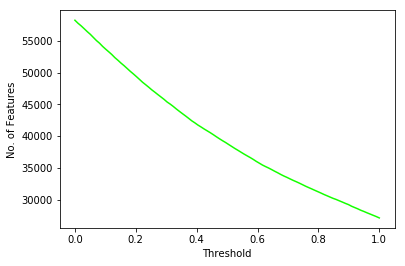

In [40]:
weightVector = perturbationTest(X_train_Vectorised_TFIDF,X_test_Vectorised_TFIDF,y_train_TFIDF,y_test_TFIDF)
afterWeight = weightVector[0][0]
weight_diff = weightVector[1][0]
feature_names = weightVector[2]

#### From the above graph, though there is no proper elbow,the threshold is considered as 0.50

In [47]:
#( ((|W-W'|+100) / (W+100))*100)
# print("The %tage change in Weights after adding Noise :" , weights_diff)
print("\t\t\tFeature Name\t\t\t\t\tWeight Difference")
for i,j,k in zip(afterWeight,weight_diff,feature_names):
    
    if j>0.5:
        print("\t\t\t{0}\t\t\t\t\t\t{1}".format(k,j))

			Feature Name					Weight Difference
			aaa						1.3392615994309367
			aaaaaaahhhhhh						1.5682253295113004
			aaaaaaarrrrrggghhh						1.0272260552465635
			aaaaaahhhhhyaaaaaa						1.8415629779897635
			aaaaaawwwwwwwwww						1.8263122295431853
			aaaahhhhhh						1.8263122295431853
			aaah						1.8263122295431853
			aaahhh						1.8263122295431853
			aabout						1.1649622341400374
			aachen						1.1649622341400374
			aacur						1.0247772977283849
			aadp						1.0247772977283849
			aadult						1.057444430295208
			aaf						1.057444430295208
			aafco						2.2128073570059867
			aagreen						2.2128073570059867
			aah						2.123589570900591
			aahh						3.725821459372299
			aahhh						1.1276919934611862
			aamazon						3.6864196323264826
			aana						1.2545194382127194
			aand						1.7451820228320893
			aap						1.7473907634175607
			aappubl						0.7351061048401736
			aar						2.3738494473314975
			aarthur						1.3165374015778852
			aasanfood						1.3165374015778852
			aback						0.85041643

			awelful						0.515343192371965
			awesom						2.613909271006075
			awesomeand						0.600650888232776
			awesomeanoth						0.9531214913716519
			awesomefor						0.5423642004457804
			awesomei						0.5279237714705979
			awesomeim						0.8191112190093158
			awesomeinterest						0.6777320016150581
			awesomeit						2.3109246658614953
			awesomeof						1.7303839853757712
			awesomeright						3.1859687804825216
			awesomesimpli						3.2783680267508943
			awesometh						0.9956817049190029
			awesomethank						1.7404956260486188
			awesomethi						0.7583309531118899
			awesometrust						0.6904555021281382
			awesomewil						3.498012032100294
			aweson						0.574294076315364
			awfulb						1.5251070036131187
			awfuli						0.6766237381499788
			awhil						0.8106189693367833
			awhol						1.0539137852143847
			awil						4.165843413977741
			awkward						4.179079407231759
			awl						3.1877111423821693
			awlway						0.6623766196865168
			awm						1.2591237285524304
			awoken						2.3536799796

			brownsveri						1.731096270137616
			brownsyrup						2.29870669806396
			brownth						2.29870669806396
			brows						0.5219548774421777
			browser						0.750221952391223
			browsersaddress						1.170216279065887
			browsingal						0.8006387086163129
			brs						0.9388462064055716
			brslng						0.5578851587599518
			brt						0.5930163911854873
			bruchetta						1.0045191535286067
			brucshett						3.2849253260447546
			bruegger						2.0066035420269848
			bruel						3.862935956900334
			bruge						3.862935956900334
			bruleei						3.836069175526096
			bruleek						3.836069175526096
			brum						0.5548985211759081
			brumasgiftshop						0.5548985211759081
			brummel						7.815581837042586
			brunch						7.815581837042586
			brunello						1.8400293950089106
			brunett						1.8400293950089106
			bruschett						1.8400293950089106
			bruschetta						1.8400293950089106
			bruse						3.7809953717912395
			brush						3.7809953717912395
			brushedand						3.4283154196469536
			brusher						3.

			cokeplus						3.0664131063815216
			cokewith						1.8566668113672704
			coki						1.5036539853030055
			cokolino						1.9074260500700873
			cola						2.2174816498408463
			colabor						0.9727344497838069
			colac						4.746359615593409
			colada						1.6553409711154563
			colae						2.2113690978445177
			colangelo						0.5912177341724477
			colata						0.8870119440130546
			colbert						3.4994703651731207
			colbi						0.5031000215953246
			colchest						4.567699826997315
			cold						3.0626380007077234
			colder						0.8896678281242534
			coldest						0.8542426442066382
			coldi						0.5376245646686438
			coldpack						2.964550221003665
			coldpak						7.031392207283764
			coldpress						4.029415072524431
			coldsth						1.6709019856267282
			coldyou						1.411934160219683
			cole						0.6557519246425542
			colemen						2.6479147068455817
			coleslaw						0.6674115447409581
			colest						1.375591572434725
			coleus						26.013960158242217
			coli						1.9055230604238853
			colic		

			digidesign						1.8433059657979427
			digit						2.987015656614211
			diglycerid						0.6146195175467225
			digniti						3.240961067342998
			digust						1.0339189259076884
			diharrea						0.6001368606710721
			dihydrateginkgo						1.2453877149398518
			diifer						1.3324464642386655
			dijom						2.0225137840621796
			dijon						1.6170012022510776
			dijonais						0.7337228192201952
			dijonnais						0.6962418762352365
			dilat						2.7880065195074324
			dilaurenti						3.972566015463537
			dilemma						3.1808108440274414
			dilemna						0.9381042221450235
			dilici						1.3025465740766604
			dilig						1.019836483751644
			dilithium						3.7865059348120984
			diliv						2.941676955910743
			dill						1.2840776536590843
			dillard						1.3829090948627327
			dilletant						3.1518716592928304
			dilli						2.8510441227096663
			dilliveri						0.8551452894238301
			dillon						0.6860183188676052
			dilusion						1.278131718771775
			dilut						0.5232725393713316
			dilutant						3.92

			favoret						1.4125399763078113
			favori						0.7877335303962061
			favorirt						1.1389448149776071
			favorit						4.783268947867483
			favoritebak						1.3080274701680565
			favoritebecaus						1.5495830503849568
			favoritebuy						1.489909775058593
			favoriteeveri						0.9115288606505956
			favoritei						2.9566365485600756
			favoritesa						2.5348825341590375
			favoritesalmon						5.8594260607161015
			favoritesi						4.0630176009679095
			favoritesinc						1.6082436398150237
			favoritesnic						2.1799257556062277
			favoriteth						4.967053348868327
			favoritethes						0.5828062032993572
			favoritethey						0.6126046368959828
			favoritetofu						1.0651093121513937
			favoritew						2.0407611025731858
			favoritewel						2.9447361879308276
			favorito						1.274209752578447
			favorti						2.4060728892055816
			favortiresi						1.849979737168005
			favour						1.7793347727027828
			favourit						0.9611263336940343
			fawourit						0.8479436503146363
			fax						2.88699

			greaduat						1.3198420101356398
			greal						0.8794532221533495
			gream						5.475570815640629
			greami						1.3100877130572754
			greapefruit						1.2400875764889465
			grear						2.270706000656971
			greaseless						3.601272570957296
			greasey						3.229243188395924
			greasi						1.8893265486620034
			greasier						1.1587421400168556
			greasyi						1.083802309188215
			greata						0.5463420539441526
			greatal						1.3936700594317677
			greatalthough						2.6413431654373944
			greatand						1.1795744475186247
			greatben						0.6666302354261902
			greatbi						1.4888261827320153
			greatbread						1.2384470187543914
			greatbreak						2.203559757730941
			greatbuy						0.7295224391781705
			greatdefinit						2.685625293475332
			greatdeliv						0.7888456392404674
			greatdidnt						0.9188355286491746
			greatdont						1.6637126027476312
			greateat						0.8180509187573937
			greater						2.225105018774669
			greatest						1.5423917169746117
			greateven						7.4081103973564

			insol						0.6066932697325798
			insolubl						1.3261303044090615
			insominia						1.4739420366764384
			insomniac						0.8321564438959851
			insomniaso						2.260412467964081
			insomuch						1.3837156035278468
			insoup						2.3162127969472235
			inspect						9.304906308212889
			inspector						0.5421219761864001
			inspit						5.010018394839886
			instabl						1.2507066680162822
			instanc						1.4939647073726219
			instancc						0.746513509000952
			instant						6.2004191411667495
			instantcoffe						0.6011247441792956
			instatnt						0.7852084413149808
			instead						0.898504897175767
			insteadani						2.0883869664393515
			insteadof						1.3340988085067667
			insteadthank						2.14720117288768
			insteadthi						1.7551986762678142
			insteadwa						3.5287024155888824
			insteadwel						5.6785990161723285
			instens						6.419110022133855
			insterest						2.89448259629594
			instig						1.1163331224582655
			instil						0.641145817560857
			instinct						1.252489988581089

			loov						3.0599997479891474
			looveee						1.1631990412747997
			looza						0.5123709322660155
			lope						6.718098202993541
			loquitor						2.097230454372054
			lorang						0.9473566409547965
			lorann						0.5914660538288019
			lord						2.991427763974558
			lore						1.6520163189196488
			loren						1.1534963607896032
			lorenza						1.817981343560947
			lorenzo						3.5708931609219583
			loret						1.4050169441428
			loreto						4.124538773840533
			loretta						1.1631990412747997
			lorina						1.5584101437656546
			lorinatur						1.882885359835649
			lorna						0.5609438922629524
			lorrain						0.5953627735317152
			los						5.878732200626243
			losei						3.642714529908595
			loser						1.6428198162165297
			lossbob						2.273242314214386
			losseshav						3.8885447783425175
			lossgreen						1.0079424915303556
			lossthi						0.5377353066270653
			lot						1.156982652367552
			lota						1.907454229494377
			lotal						6.718098202993541
			lotdont						0.66551941763046
	

			mixologist						6.149308569288159
			mixon						4.200102138113584
			mixpit						3.112071003992119
			mixpreheat						1.197994686132608
			mixserv						1.1529544144621091
			mixthi						0.8139506262681192
			mixtur						0.8507457558985845
			mixturestir						0.629443493870376
			mixup						3.7477447137516195
			mixur						0.7145992583934221
			mixus						1.1560780736904568
			mixx						1.463833416103841
			mixø						1.3121637688989287
			miyagi						3.212739744436769
			miztur						3.3281339317180985
			mizuki						3.9647059844442536
			mjg						3.8066190160606803
			mjr						3.769201302980777
			mking						0.6414305275978691
			mks						2.339095807790106
			mkt						6.37722085697801
			mlamount						17.491177668476602
			mlb						1.663030276901744
			mlbetter						1.265773667660175
			mlf						0.8795976111509464
			mlfsd						2.397685694264052
			mljohnni						0.7792471711324892
			mlk						5.07937570795389
			mlm						1.926983675346617
			mls						0.581853087151526
			mmf						0.8

			oneyou						5.2668560347108615
			onfirm						1.358380616777726
			ongo						2.8716115045680795
			onhand						3.244410706340569
			onher						1.8976186233010433
			oni						1.2346973935985928
			onif						1.1670009042224916
			onigri						0.8379282421589607
			onin						1.5436108872656362
			oniongarlicoreganosoya						1.630194732542059
			onionon						0.7912063416090838
			onionsliv						1.1773068665016821
			onionvintag						0.7989285634996741
			onlin						2.486546435695855
			onlinea						0.6358122118052777
			onlinealmost						1.4059124838892951
			onlinei						1.8285146653303423
			onlinen						2.032488615038351
			onlinethank						1.0470238174836892
			onlycomplaint						0.5018094481929879
			onlyearth						1.8194415524831906
			onlyg						1.4323272645964158
			onlygf						0.8508517837241643
			onlygreen						1.0836740523124906
			onlygrip						0.9800073467618775
			onlylik						0.7051787661266029
			onlyseawe						3.855402957680952
			onlysold						2.1995787684564116
			onl

			plumros						0.6135160110141983
			plung						0.7418049550047066
			plungent						1.9992266444046982
			plural						4.090425752017973
			pluribus						0.619771319271887
			plus						2.853610905447982
			plusanoth						1.840106399415959
			pluse						1.4231390135752924
			plush						1.592239624355444
			plushi						1.624904182244382
			plusi						1.560276558039059
			plusnatur						1.617352770452243
			pluss						0.5156572834542382
			pluto						0.8982526370235139
			plyabl						2.933456724509251
			plymouth						0.9622182308367345
			plz						1.0141181603684268
			pmfull						9.989135411371928
			pmill						3.561443049729292
			pminiti						5.731918447200993
			pmkristin						2.2977970436651516
			pmmake						0.7462773438812208
			pmsing						0.690538513088293
			pneumat						0.6209662094314313
			pneumonia						5.879351542729629
			png						0.9576952494840144
			pnw						1.013499563049893
			po						0.8663762935678934
			poa						0.6728014878237281
			poach						0.5260103048838254


			riboflavin						1.1686743055564843
			ribsdirectionswash						1.480749060337023
			ribsthey						2.5755443904846596
			ric						1.9761574720257729
			rica						2.39340865266197
			ricanvan						1.0035273026187377
			ricardo						1.127793779328376
			riceb						1.7177020442817774
			ricebal						0.9841561842737682
			ricebravothank						2.3558686124245307
			ricedo						0.5241401858409394
			ricemak						3.1367501991346884
			ricemilk						1.6805666451123025
			riceon						0.6684405961478445
			ricepatak						1.177638945497792
			ricequickniceplump						4.858017316279054
			riceselect						3.4726581658870463
			riceselet						3.3217163675550156
			ricesoy						1.0753004300572477
			riceth						2.0033354256546563
			ricether						0.6669430042040211
			riceto						13.375423462962862
			ricework						3.576777116300759
			ricey						2.0474605290175227
			rich						2.802094915442652
			richardson						2.186565211783543
			richer						1.8928549618462438
			richerand						0.8989967983208493

			settingmilk						3.6073325339801663
			settingpeppermint						1.6719814940599345
			settingsextra						0.755859618590085
			settingthes						0.8736664231480417
			settlement						3.0180972642257236
			settler						2.1978192719861536
			settletri						1.7160550408977258
			setup						0.6605934852903549
			seuss						2.4742611440618454
			sevar						3.0021688653367873
			seve						2.7212339393240295
			seveal						0.7714386386599247
			seventeen						1.365549963746997
			seventh						0.7337239432290907
			seventi						0.8412214612071209
			severalflavor						2.5019811795449964
			severalhour						1.1694971238755205
			severalof						0.5090045712267777
			severalyear						1.2461909637424218
			severl						2.3949094591262328
			sevew						0.7059474583614384
			sevic						3.6483107456001655
			sevich						1.942329495335702
			seviervill						1.1079790693764306
			sevill						0.9612830164243715
			sevingand						3.3937968063472823
			sevita						0.8615567074309922
			sevl						3.275627100

			sujata						4.242916666455714
			sukhi						1.1484681123787424
			sukiyaki						0.9383174354484205
			sul						2.9541423758514753
			sulawesi						2.3332841453331965
			sulfer						5.827009872633866
			sulfid						1.7842117471552847
			sulfur						1.6108747113884259
			sullivan						1.8115951959187688
			sulpher						1.94559812529628
			sulphur						10.61646955380635
			sultan						3.083492400674266
			sultana						0.5198859080846898
			sultri						0.9215563018961515
			sumac						5.524014885159441
			sumarta						0.7399277366632315
			sumatra						1.9240727654890746
			sumatran						2.066786731015824
			summac						0.7941702603099164
			summah						3.0839598306521556
			summari						1.0868275369291505
			summarili						0.7391257335485746
			summaris						1.761327929264135
			summarydont						0.7743135844946181
			summaryif						0.5529902809698062
			summat						1.8600439557209685
			summer						3.1712133963360167
			summon						0.9338897945934853
			sumo						4.228280837979169
			s

			treatsto						3.141024048743172
			treatstwo						0.963859902302313
			treatswww						0.9240678811244465
			treatt						0.825657772286168
			treatth						7.1862133308528255
			treatthank						1.1928759376787235
			treatthes						6.2611298314938235
			treatthi						2.1445587584639254
			treattri						30.057442017796543
			trebbiano						0.9203482040726084
			trebor						0.5368266134897046
			treck						0.8218215272409192
			tred						7.4937911281954275
			tree						3.0783085458653385
			treee						1.2190175144562239
			treeeeeat						0.614479756909641
			treehous						1.8891933681640025
			treehugg						2.386010917874747
			treei						6.4491821179397375
			treemount						0.633049112049827
			treenut						0.8331585757644238
			treet						0.7705352946482833
			treetop						2.7175599270773825
			treid						0.5835315543885375
			treir						3.8261558511113742
			trek						3.0091311071114935
			trekk						3.0091311071114935
			trelli						1.738323342222003
			trellis						0.865012422253038

			whimsi						3.596709316442807
			whimsic						1.1580176338443522
			whin						0.9143005772281115
			whiner						1.223226083692254
			whini						1.8630957251923441
			whip						0.5955404169743028
			whipit						1.715201624890138
			whipp						1.1830379813213407
			whipper						8.885635250371744
			whippersnapp						2.2153297781015797
			whippet						0.9327022429030973
			whir						4.273126931743527
			whirey						8.391266069504132
			whirl						1.070987292351505
			whirley						2.9512771354819947
			whirleypop						1.6866481508707565
			whirr						3.550697027313788
			whirrrrr						6.212902172585359
			whis						1.32392498122599
			whisch						2.7342972162158588
			whish						1.232809201480235
			whisk						2.5113279176854886
			whiska						2.4052868320429193
			whisker						2.130848270476993
			whiski						1.855120207334313
			whiskyi						6.361908907415871
			whisp						0.600477306267443
			whisper						0.5800301981823192
			whistleblow						2.3629003663308024
			whit						1.133583

### Find Important Features for both Positive and Negative Class

In [42]:
#Most Important Features
def mostImportantFeatures(X_Train,Y_Train,vectorizer, logistics, n=25):
    logistics.fit(X_Train,Y_Train)
    featureNames = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(logistics.coef_[0], featureNames))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

        





In [43]:
logistics = LogisticRegression(C= 10, penalty= 'l2',n_jobs = -1)

print("Most Important Features for BoW")
mostImportantFeatures(X_Train_BOW,y_train_BOW,vect,logistics)

Most Important Features for BoW
			Negative						Positive
________________________________________________________________________________________________
	-3.7797	peed           				3.7750	hiss           
	-3.7581	compass        				3.7653	deduct         
	-3.6053	undrink        				3.6461	haha           
	-3.4114	scooter        				3.4911	perruch        
	-3.3870	tallow         				3.4512	emeraldforest  
	-3.2985	unimpress      				3.2470	tribut         
	-3.2893	worst          				3.2256	exuber         
	-3.2630	unpalat        				3.1981	niacin         
	-3.2009	onward         				2.9999	easiest        
	-3.1960	perkyo         				2.9943	tantal         
	-3.1643	stassen        				2.9914	skeptic        
	-3.1496	weruvia        				2.9229	bound          
	-3.1323	unapp          				2.8824	chedder        
	-3.1302	powergel       				2.7253	ambrosia       
	-3.1172	robitussin     				2.7135	pickiest       
	-3.0691	unforun        				2.7102	gorgeous       
	-3.0565	instantto      				2

In [57]:
print("Most Important Features for TFIDF")
mostImportantFeatures(X_train_Vectorised_TFIDF,y_train_TFIDF,tf_idf_vect,logistics)

Most Important Features for TFIDF
			Negative						Positive
________________________________________________________________________________________________
	-21.8275	disappoint     				23.9108	great          
	-20.3482	worst          				22.0233	delici         
	-16.2565	terribl        				20.5008	best           
	-15.5532	aw             				19.3711	love           
	-14.3845	horribl        				18.6801	perfect        
	-14.1772	return         				16.4842	excel          
	-13.5982	unfortun       				16.4805	high recommend 
	-13.1035	two star       				14.3038	amaz           
	-13.0174	bland          				13.9549	nice           
	-12.5150	threw          				13.9399	good           
	-12.0298	stale          				12.0082	favorit        
	-12.0024	wont buy       				11.6188	fantast        
	-11.9562	disgust        				11.5428	yummi          
	-11.8226	tasteless      				11.3164	easi           
	-11.5134	weak           				11.0409	awesom         
	-11.0560	sorri          				11.0098	wont disapp